In [9]:
# 📚 1. Import thư viện

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from sklearn.metrics import average_precision_score


In [2]:
url = "https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv"
df = pd.read_csv(url)

print("Kích thước dữ liệu gốc:", df.shape)
print(df['Class'].value_counts())

Kích thước dữ liệu gốc: (284807, 31)
Class
0    284315
1       492
Name: count, dtype: int64


In [3]:
# ⚙️ 3. Tạo tập con 2000 mẫu, giữ tỷ lệ mất cân bằng ban đầu (~0.172%)

fraud = df[df['Class'] == 1]
non_fraud = df[df['Class'] == 0]

target_size = 2000
fraud_ratio = len(fraud) / len(df)
n_fraud = max(1, int(target_size * fraud_ratio))   # ~3 mẫu gian lận
n_non_fraud = target_size - n_fraud

fraud_sample = fraud.sample(n=n_fraud, random_state=42)
non_fraud_sample = non_fraud.sample(n=n_non_fraud, random_state=42)

df_small = pd.concat([fraud_sample, non_fraud_sample]).sample(frac=1, random_state=42).reset_index(drop=True)

print("Kích thước tập con:", df_small.shape)
print(df_small['Class'].value_counts())
print(f"Tỷ lệ gian lận: {df_small['Class'].mean() * 100:.4f}%")


Kích thước tập con: (2000, 31)
Class
0    1997
1       3
Name: count, dtype: int64
Tỷ lệ gian lận: 0.1500%


In [4]:
# 🔍 4. Tiền xử lý dữ liệu

X = df_small.drop('Class', axis=1)
y = df_small['Class']

# Chuẩn hóa cột Amount (Time có thể bỏ hoặc giữ nguyên)
scaler = StandardScaler()
X['Amount'] = scaler.fit_transform(X[['Amount']])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Kích thước train/test:", X_train.shape, X_test.shape)
print("Tỷ lệ class trong train:", np.bincount(y_train))


Kích thước train/test: (1600, 30) (400, 30)
Tỷ lệ class trong train: [1598    2]


In [5]:
# 🧩 5. Mô hình 1: SVM với class_weight='balanced'

svm_bal = SVC(kernel='rbf', C=1, probability=True, class_weight='balanced', random_state=42)
svm_bal.fit(X_train, y_train)

y_pred_bal = svm_bal.predict(X_test)
y_proba_bal = svm_bal.predict_proba(X_test)[:, 1]

print("==== Kết quả: SVM (class_weight='balanced') ====")
print(classification_report(y_test, y_pred_bal, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_bal))


==== Kết quả: SVM (class_weight='balanced') ====
              precision    recall  f1-score   support

           0     0.9971    0.8697    0.9290       399
           1     0.0000    0.0000    0.0000         1

    accuracy                         0.8675       400
   macro avg     0.4986    0.4348    0.4645       400
weighted avg     0.9946    0.8675    0.9267       400

ROC-AUC: 0.5137844611528822


In [7]:
# ⚖️ 6. Cân bằng dữ liệu bằng oversampling thủ công (bootstrap 1:1)

X1 = X_train[y_train == 1]
X0 = X_train[y_train == 0]

# Nhân bản lớp fraud để đạt tỷ lệ 1:1
X1_over = X1.sample(n=len(X0), replace=True, random_state=42)

X_train_over = pd.concat([X0, X1_over], axis=0)
y_train_over = np.concatenate([np.zeros(len(X0), dtype=int), np.ones(len(X1_over), dtype=int)])

print("Trước cân bằng:", np.bincount(y_train))
print("Sau oversampling:", np.bincount(y_train_over))


Trước cân bằng: [1598    2]
Sau oversampling: [1598 1598]


In [10]:
# 🧩 7. Mô hình 2: SVM với dữ liệu đã cân bằng (oversampling 1:1)

svm_over = SVC(kernel='rbf', C=1, probability=True, random_state=42)
svm_over.fit(X_train_over, y_train_over)

y_pred_over = svm_over.predict(X_test)
y_proba_over = svm_over.predict_proba(X_test)[:, 1]

print("==== Kết quả: SVM + Oversampling ====")
print(classification_report(y_test, y_pred_over, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_over))
print("PR-AUC:", average_precision_score(y_test, y_proba_over))


==== Kết quả: SVM + Oversampling ====
              precision    recall  f1-score   support

           0     0.9972    0.8772    0.9333       399
           1     0.0000    0.0000    0.0000         1

    accuracy                         0.8750       400
   macro avg     0.4986    0.4386    0.4667       400
weighted avg     0.9947    0.8750    0.9310       400

ROC-AUC: 0.36215538847117795
PR-AUC: 0.0025


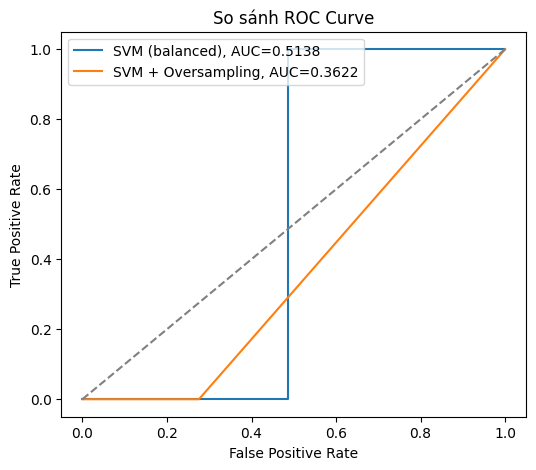

In [11]:
# 📊 8. So sánh ROC Curve và PR Curve

fpr1, tpr1, _ = roc_curve(y_test, y_proba_bal)
fpr2, tpr2, _ = roc_curve(y_test, y_proba_over)

plt.figure(figsize=(6,5))
plt.plot(fpr1, tpr1, label='SVM (balanced), AUC=%.4f' % roc_auc_score(y_test, y_proba_bal))
plt.plot(fpr2, tpr2, label='SVM + Oversampling, AUC=%.4f' % roc_auc_score(y_test, y_proba_over))
plt.plot([0,1],[0,1],'--',color='gray')
plt.title("So sánh ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


In [12]:
# 🎬 DEMO: Dự đoán trên tập con (dataset nhỏ ~2000 mẫu)
import random
import pandas as pd

# chọn ngẫu nhiên 5 mẫu test
idxs = random.sample(range(len(X_test)), 5)
samples = X_test.iloc[idxs]
true_labels = y_test.iloc[idxs].values

# dự đoán xác suất và nhãn
proba = svm_over.predict_proba(samples)[:, 1]
pred = (proba >= 0.5).astype(int)

# tạo bảng kết quả demo
demo = pd.DataFrame({
    "Thực tế": true_labels,
    "Dự đoán": pred,
    "Xác suất gian lận": proba
})

print("🔍 DEMO DỰ ĐOÁN 5 MẪU TỪ TẬP TEST (dataset con):")
print(demo)


🔍 DEMO DỰ ĐOÁN 5 MẪU TỪ TẬP TEST (dataset con):
   Thực tế  Dự đoán  Xác suất gian lận
0        0        0       1.000000e-07
1        0        0       8.402116e-04
2        0        0       1.000000e-07
3        0        1       9.051870e-01
4        0        0       1.000000e-07
